<a href="https://colab.research.google.com/github/TheUnknown477/Fraud-detection-using-deep-learning/blob/main/Fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection Using Deep Learning

## Introduction

Online payment fraud is a growing threat to financial institutions and consumers worldwide. With the rapid growth of digital transactions, traditional rule-based fraud detection systems struggle to keep pace with increasingly sophisticated fraud patterns. This project explores the use of **deep learning** combined with **adaptive streaming techniques** to build a robust fraud detection system.

### Motivation
- Fraud patterns evolve over time (concept drift), making static models less effective.
- Class imbalance is extreme — fraud cases are typically < 4% of all transactions.
- Real-world systems must process transactions as a stream with delayed label feedback.

### Approach
1. **Baseline Models**: We train traditional ML classifiers (XGBoost, Random Forest, SVM, KNN) on historical data.
2. **Deep Learning (MLP)**: A multi-layer perceptron with batch normalization and dropout serves as our primary model.
3. **MC Dropout Uncertainty**: Monte Carlo Dropout estimates prediction uncertainty at inference time.
4. **Adaptive Streaming**: Using ADWIN drift detection and an uncertainty-driven replay buffer, the model adapts to distributional shifts in the transaction stream.

### Dataset
We use the [IEEE-CIS Fraud Detection](https://www.kaggle.com/c/ieee-fraud-detection) dataset from Kaggle, which contains real-world e-commerce transaction data with engineered features.

### Metrics
- **ROC-AUC**: Area under the Receiver Operating Characteristic curve.
- **PR-AUC**: Area under the Precision-Recall curve (more informative for imbalanced data).
- **Recall@5%FPR**: Recall achieved at a 5% false positive rate threshold.

# 1. SETUP & IMPORTS

In [ ]:
!pip install kaggle river torch torchvision torchaudio scikit-learn xgboost --quiet

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import xgboost as xgb
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (precision_recall_curve, roc_auc_score, roc_curve,
                             auc, recall_score, confusion_matrix)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from river.drift import ADWIN
from collections import deque
import matplotlib.pyplot as plt
import joblib
import os

# Reproducibility seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

plt.style.use('seaborn-v0_8-whitegrid')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 79.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
Using device: cuda


# 2. SECURE KAGGLE DATA DOWNLOAD

In [ ]:
from google.colab import files
print("Please upload your kaggle.json file now:")
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c ieee-fraud-detection -p /content/data
!unzip -q /content/data/ieee-fraud-detection.zip -d /content/data


Please upload your kaggle.json file now:


Saving kaggle.json to kaggle.json
 89% 105M/118M [00:00<00:00, 1.06GB/s]
100% 118M/118M [00:00<00:00, 846MB/s] 


# 3. DATA & PREPROCESSING

In [ ]:
# Load data
train_tr = pd.read_csv('/content/data/train_transaction.csv')
train_id = pd.read_csv('/content/data/train_identity.csv')
data = train_tr.merge(train_id, on='TransactionID', how='left')

# Define features
target_col = 'isFraud'
time_col = 'TransactionDT'
feature_cols = [
    'TransactionDT', 'TransactionAmt', 'ProductCD',
    'card1','card2','card3','card4',
    'addr1','DeviceType',
    'V12','V13','V14','V15'
]

# Sort by time for streaming simulation
data = data[feature_cols + [target_col]].sort_values(time_col).reset_index(drop=True)

# Handling Missing Values
for col in data.columns:
    if data[col].dtype == 'O':
        data[col] = data[col].fillna('missing')
    else:
        data[col] = data[col].fillna(data[col].median())

# Encoding Categoricals
cat_cols = ['ProductCD', 'card4', 'DeviceType']
encoders_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))
    encoders_dict[col] = le

# Identify numeric columns (excluding time & target)
num_cols = [c for c in data.columns if c not in cat_cols + [target_col, time_col]]

# Scaling Numerics
scaler = StandardScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])

# Save input feature order for the App
feature_input_cols = num_cols + cat_cols

# Split: 60% Historical (Train), 40% Streaming (Test)
split_idx = int(0.6 * len(data))
hist_df = data.iloc[:split_idx].reset_index(drop=True)
stream_df = data.iloc[split_idx:].reset_index(drop=True)

# Calculate Class Weight for Imbalance
neg_count = (hist_df[target_col] == 0).sum()
pos_count = (hist_df[target_col] == 1).sum()
pos_weight = torch.tensor([neg_count / pos_count]).to(device)
print(f"Historical set: {len(hist_df)}, Streaming set: {len(stream_df)}")
print(f"Fraud Ratio: {pos_count/len(hist_df):.4f}, Pos Weight: {pos_weight.item():.2f}")

Historical set: 354324, Streaming set: 236216
Fraud Ratio: 0.0338, Pos Weight: 28.56


# 4. Utility Functions: Metrics

In [ ]:
def mc_predict(model, X, T=20):
    model.eval() # Set model to evaluation mode (disables Batchnorm training and Dropout)
    # Manually re-enable dropout layers for MC Dropout
    for module in model.modules():
        if isinstance(module, nn.Dropout):
            module.train() # Re-enable dropout

    probs = []
    with torch.no_grad():
        for _ in range(T):
            logits = model(X)
            probs.append(torch.sigmoid(logits).cpu().numpy())
    probs = np.stack(probs, axis=0)

    # Restore original model state (eval mode for all layers) after MC Dropout
    model.eval()

    # Return mean prob and variance
    return probs.mean(axis=0).reshape(-1), probs.var(axis=0).reshape(-1)

def compute_metrics(y_true, y_score):
    if len(np.unique(y_true)) < 2: return None
    roc = roc_auc_score(y_true, y_score)
    pr, rc, _ = precision_recall_curve(y_true, y_score)

    # Recall at 5% FPR
    fpr_target = 0.05
    # Sort scores descending
    desc_score_indices = np.argsort(y_score)[::-1]
    y_score_sorted = np.array(y_score)[desc_score_indices]
    y_true_sorted = np.array(y_true)[desc_score_indices]

    # Find threshold index for 5% FPR
    neg_count = (y_true_sorted == 0).sum()
    fp_limit = neg_count * fpr_target
    fp_count = 0
    cutoff_idx = len(y_true_sorted)

    for i, label in enumerate(y_true_sorted):
        if label == 0: fp_count += 1
        if fp_count > fp_limit:
            cutoff_idx = i
            break

    # Calculate recall up to that cutoff
    if np.sum(y_true_sorted) > 0:
        recall_at_fpr = np.sum(y_true_sorted[:cutoff_idx]) / np.sum(y_true_sorted)
    else:
        recall_at_fpr = 0.0

    return {"roc_auc": roc, "pr_auc": auc(rc, pr), "recall_at_5fpr": recall_at_fpr}

# 5. BASELINE: XGBoost

In [ ]:
print("\nTraining XGBoost Baseline...")
xgb_clf = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    scale_pos_weight=pos_weight.item(),
    eval_metric='auc'
)
xgb_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_xgb = xgb_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
y_true_stream = stream_df[target_col].values

xgb_metrics = compute_metrics(y_true_stream, y_pred_xgb)
print(f"XGBoost — ROC-AUC: {xgb_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {xgb_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {xgb_metrics['recall_at_5fpr']:.4f}")


Training XGBoost Baseline...
XGBoost — ROC-AUC: 0.7773, PR-AUC: 0.1803, Recall@5%FPR: 0.3703


# 5B. Additional Baselines: Random Forest, SVM, KNN

In [ ]:
# --- Random Forest ---
print("Training Random Forest...")
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_rf = rf_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
rf_metrics = compute_metrics(y_true_stream, y_pred_rf)
print(f"Random Forest — ROC-AUC: {rf_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {rf_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {rf_metrics['recall_at_5fpr']:.4f}")

# --- SVM (SGDClassifier with hinge loss) ---
print("\nTraining SVM (SGDClassifier)...")
sgd_clf = SGDClassifier(
    loss='hinge',
    class_weight='balanced',
    random_state=42,
    max_iter=1000
)
svm_clf = CalibratedClassifierCV(sgd_clf, cv=3)
svm_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_svm = svm_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
svm_metrics = compute_metrics(y_true_stream, y_pred_svm)
print(f"SVM — ROC-AUC: {svm_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {svm_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {svm_metrics['recall_at_5fpr']:.4f}")

# --- KNN ---
print("\nTraining KNN...")
knn_clf = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_clf.fit(hist_df[feature_input_cols], hist_df[target_col])
y_pred_knn = knn_clf.predict_proba(stream_df[feature_input_cols])[:, 1]
knn_metrics = compute_metrics(y_true_stream, y_pred_knn)
print(f"KNN — ROC-AUC: {knn_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {knn_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {knn_metrics['recall_at_5fpr']:.4f}")

Training Random Forest...
Random Forest — ROC-AUC: 0.7706, PR-AUC: 0.1650, Recall@5%FPR: 0.3451

Training SVM (SGDClassifier)...
SVM — ROC-AUC: 0.7474, PR-AUC: 0.1016, Recall@5%FPR: 0.2052

Training KNN...
KNN — ROC-AUC: 0.6361, PR-AUC: 0.1448, Recall@5%FPR: 0.2531


# 6. DEEP LEARNING MODEL

In [ ]:
class FraudDataset(Dataset):
    def __init__(self, df):
        self.X = torch.tensor(df[feature_input_cols].values, dtype=torch.float32)
        self.y = torch.tensor(df[target_col].values, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

class MLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128), nn.BatchNorm1d(128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1) # No Sigmoid here, handled by BCEWithLogitsLoss
        )
    def forward(self, x): return self.net(x)

# 7. Initial Training (Static Baseline)

In [ ]:
train_ds = FraudDataset(hist_df)
train_loader = DataLoader(train_ds, batch_size=2048, shuffle=True)

model = MLP(input_dim=len(feature_input_cols)).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

training_losses = []
print("\nTraining Initial Static Model...")
for epoch in range(5):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device).view(-1,1)
        optimizer.zero_grad()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * len(X_batch)
    avg_loss = total_loss / len(train_ds)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

# Compute MLP static baseline metrics on stream data
model.eval()
with torch.no_grad():
    X_stream = torch.tensor(stream_df[feature_input_cols].values, dtype=torch.float32).to(device)
    mlp_static_probs = torch.sigmoid(model(X_stream)).cpu().numpy().reshape(-1)

mlp_static_metrics = compute_metrics(y_true_stream, mlp_static_probs)
print(f"\nMLP Static — ROC-AUC: {mlp_static_metrics['roc_auc']:.4f}, "
      f"PR-AUC: {mlp_static_metrics['pr_auc']:.4f}, "
      f"Recall@5%FPR: {mlp_static_metrics['recall_at_5fpr']:.4f}")


Training Initial Static Model...
Epoch 1, Loss: 1.2015
Epoch 2, Loss: 1.1690
Epoch 3, Loss: 1.1575
Epoch 4, Loss: 1.1503
Epoch 5, Loss: 1.1437

MLP Static — ROC-AUC: 0.7544, PR-AUC: 0.1327, Recall@5%FPR: 0.2922


# 8. EXPERIMENT: FULL METHOD

In [ ]:
def run_full_method(df, delay=1000, chunk=50000):
    print("\nRunning Full Adaptive Method with Uncertainty & Drift Detection...")
    adwin = ADWIN()
    label_queue = deque()
    replay_buffer = []
    drift_points = []
    metrics_log = []

    chunk_y_true, chunk_y_pred = [], []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for i, row in df.iterrows():
        X = torch.tensor(row[feature_input_cols].values, dtype=torch.float32).unsqueeze(0).to(device)
        y = int(row[target_col])

        # 1. Inference with Uncertainty
        mean_p, var_p = mc_predict(model, X)
        pred_prob = float(mean_p[0])

        chunk_y_true.append(y)
        chunk_y_pred.append(pred_prob)

        # 2. Delayed Label Queue
        is_uncertain = var_p[0] > 0.02 # Tune threshold if needed
        label_queue.append((X, y, is_uncertain))

        # 3. Label Reveal & Update
        if len(label_queue) > delay:
            past_X, past_y, was_uncertain = label_queue.popleft()

            # Drift Check
            model.eval()
            with torch.no_grad():
                drift_prob = torch.sigmoid(model(past_X)).item()
                drift_pred = 1 if drift_prob >= 0.5 else 0

            err = int(drift_pred != past_y)
            adwin.update(err)

            if adwin.drift_detected:
                drift_points.append(i)

            # Update Strategy
            if was_uncertain or adwin.drift_detected:
                replay_buffer.append((past_X, past_y))

            # Mini-batch update
            if len(replay_buffer) >= 64:
                batch = replay_buffer[-64:]
                bX = torch.cat([b[0] for b in batch])
                by = torch.tensor([b[1] for b in batch], dtype=torch.float32).view(-1,1).to(device)

                model.train()
                optimizer.zero_grad()
                loss = criterion(model(bX), by)
                loss.backward()
                optimizer.step()
                replay_buffer = []

        # 4. Logging
        if (i+1) % chunk == 0:
            m = compute_metrics(chunk_y_true, chunk_y_pred)
            if m:
                m['index'] = i
                metrics_log.append(m)
                print(f"Index {i}: PR-AUC={m['pr_auc']:.4f}, Recall@5%FPR={m['recall_at_5fpr']:.4f}, Drifts={len(drift_points)}")
            chunk_y_true, chunk_y_pred = [], []

    return metrics_log, drift_points

# Run it!
metrics_log, drift_points = run_full_method(stream_df)


Running Full Adaptive Method with Uncertainty & Drift Detection...
Index 49999: PR-AUC=0.1580, Recall@5%FPR=0.3212, Drifts=19
Index 99999: PR-AUC=0.1055, Recall@5%FPR=0.2260, Drifts=38
Index 149999: PR-AUC=0.0945, Recall@5%FPR=0.2401, Drifts=48
Index 199999: PR-AUC=0.1066, Recall@5%FPR=0.2644, Drifts=67


# 9. RESULTS & PLOTTING

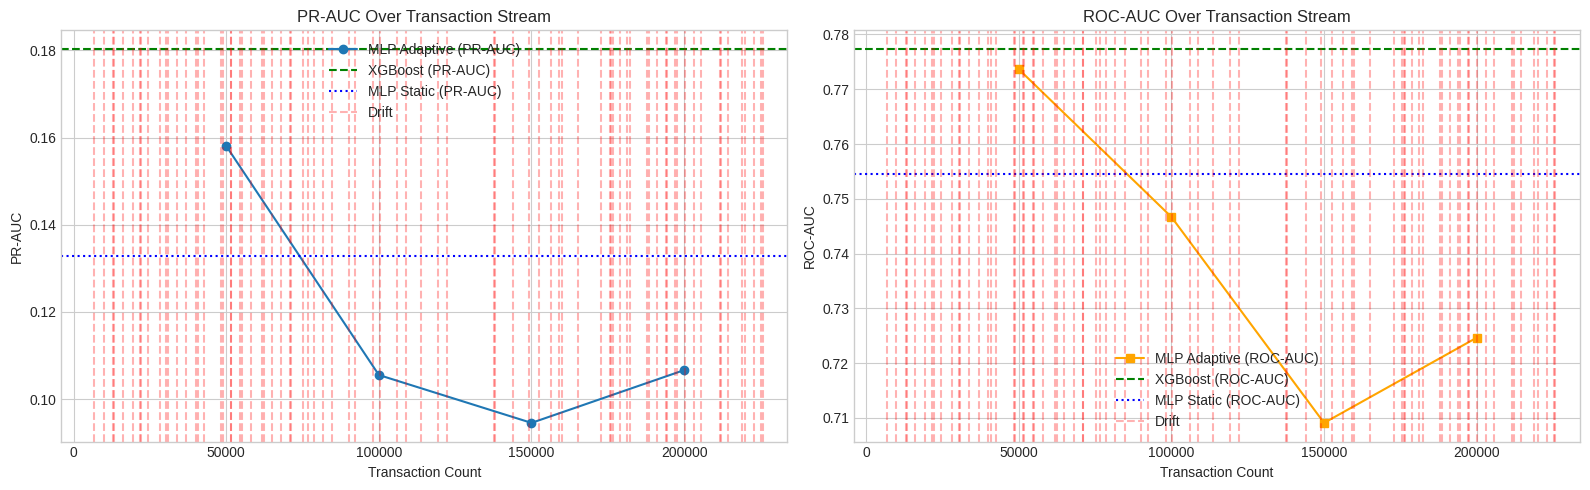

In [ ]:
df_res = pd.DataFrame(metrics_log)

# Compute MLP Adaptive final metrics from the full streaming run
# (Use the last chunk's metrics if available, otherwise use overall)
if not df_res.empty:
    mlp_adaptive_metrics = {
        'roc_auc': df_res['roc_auc'].iloc[-1],
        'pr_auc': df_res['pr_auc'].iloc[-1],
        'recall_at_5fpr': df_res['recall_at_5fpr'].iloc[-1]
    }
else:
    mlp_adaptive_metrics = {'roc_auc': 0, 'pr_auc': 0, 'recall_at_5fpr': 0}

# --- Plot 9 (fixed): Adaptive Method Performance Over Stream ---
if not df_res.empty:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))

    # PR-AUC over stream
    axes[0].plot(df_res['index'], df_res['pr_auc'], marker='o', label='MLP Adaptive (PR-AUC)')
    axes[0].axhline(y=xgb_metrics['pr_auc'], color='g', linestyle='--', label='XGBoost (PR-AUC)')
    axes[0].axhline(y=mlp_static_metrics['pr_auc'], color='b', linestyle=':', label='MLP Static (PR-AUC)')
    first_drift = True
    for d in drift_points:
        if first_drift:
            axes[0].axvline(d, color='r', linestyle='--', alpha=0.3, label='Drift')
            first_drift = False
        else:
            axes[0].axvline(d, color='r', linestyle='--', alpha=0.3)
    axes[0].set_title('PR-AUC Over Transaction Stream')
    axes[0].set_xlabel('Transaction Count')
    axes[0].set_ylabel('PR-AUC')
    axes[0].legend()
    axes[0].grid(True)

    # ROC-AUC over stream
    axes[1].plot(df_res['index'], df_res['roc_auc'], marker='s', color='orange', label='MLP Adaptive (ROC-AUC)')
    axes[1].axhline(y=xgb_metrics['roc_auc'], color='g', linestyle='--', label='XGBoost (ROC-AUC)')
    axes[1].axhline(y=mlp_static_metrics['roc_auc'], color='b', linestyle=':', label='MLP Static (ROC-AUC)')
    first_drift = True
    for d in drift_points:
        if first_drift:
            axes[1].axvline(d, color='r', linestyle='--', alpha=0.3, label='Drift')
            first_drift = False
        else:
            axes[1].axvline(d, color='r', linestyle='--', alpha=0.3)
    axes[1].set_title('ROC-AUC Over Transaction Stream')
    axes[1].set_xlabel('Transaction Count')
    axes[1].set_ylabel('ROC-AUC')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('adaptive_performance_plot.png', dpi=150, bbox_inches='tight')
    plt.show()

# 9B. Comprehensive Visualizations

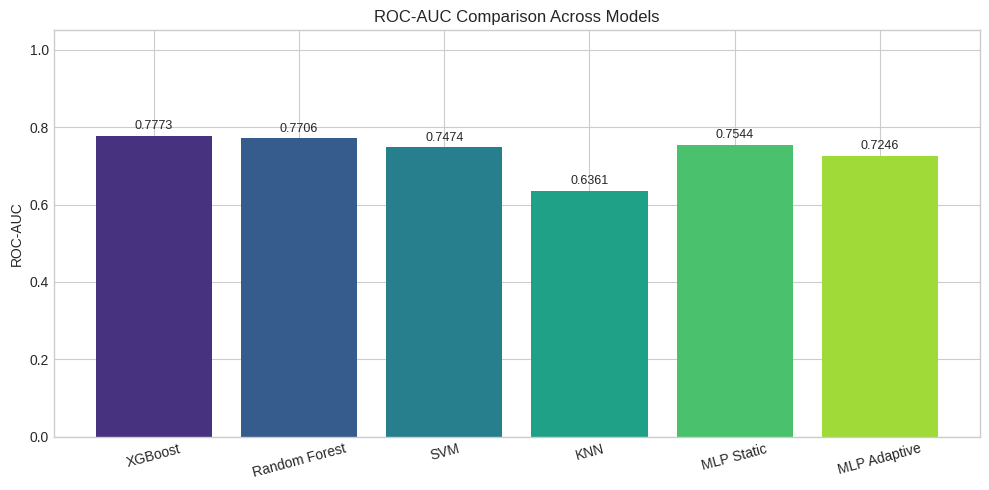

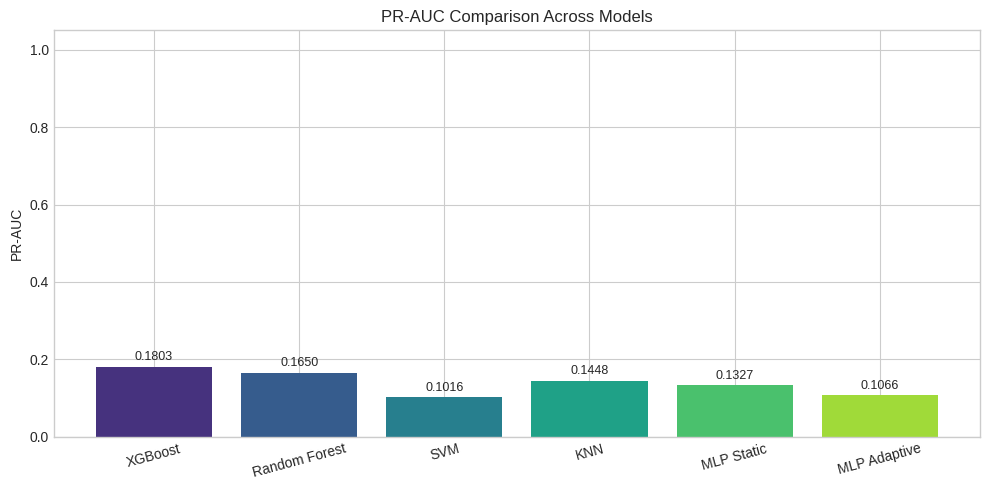

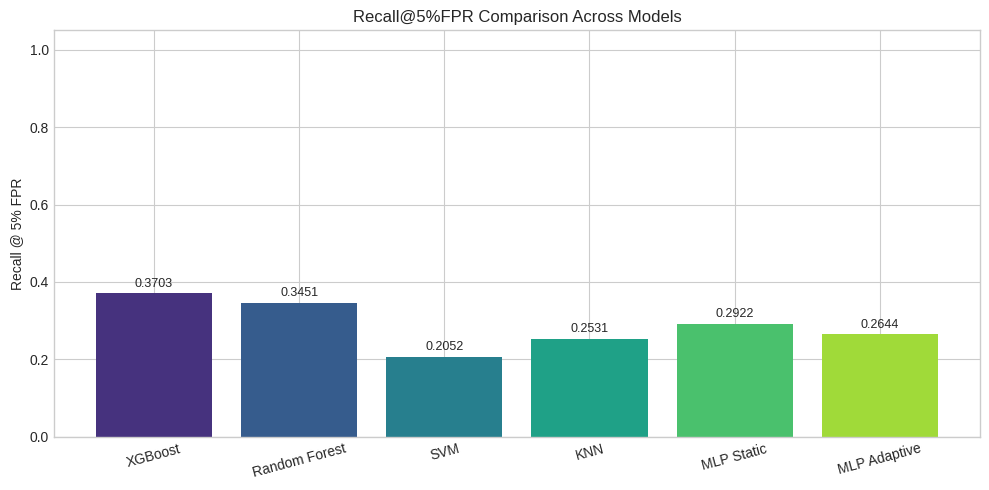

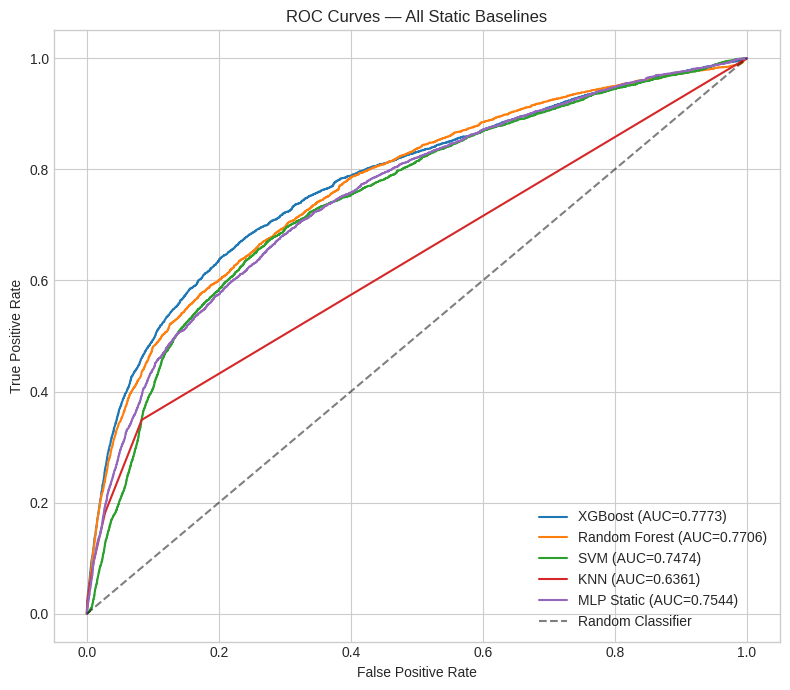

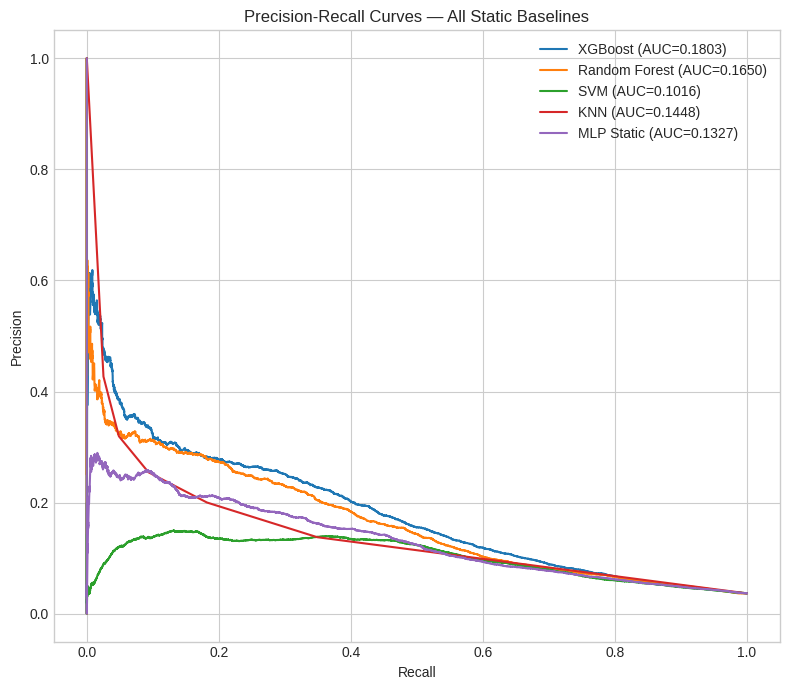

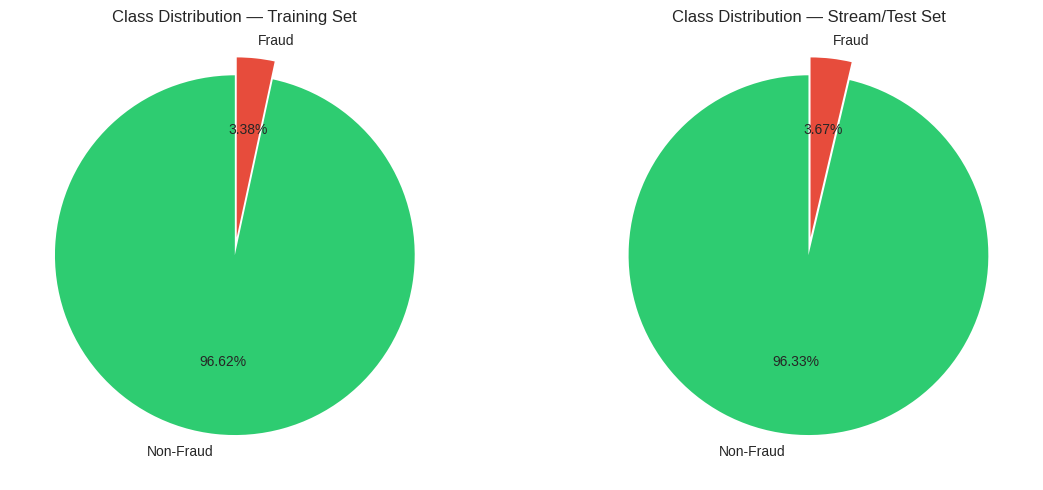

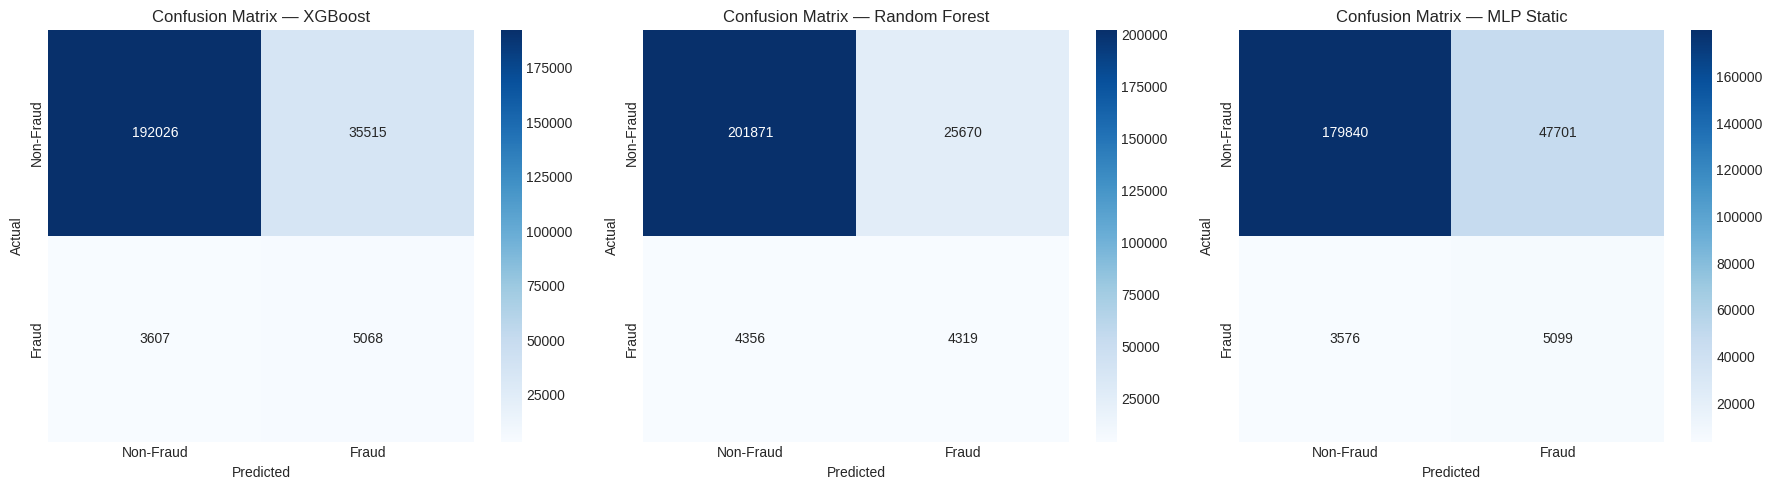

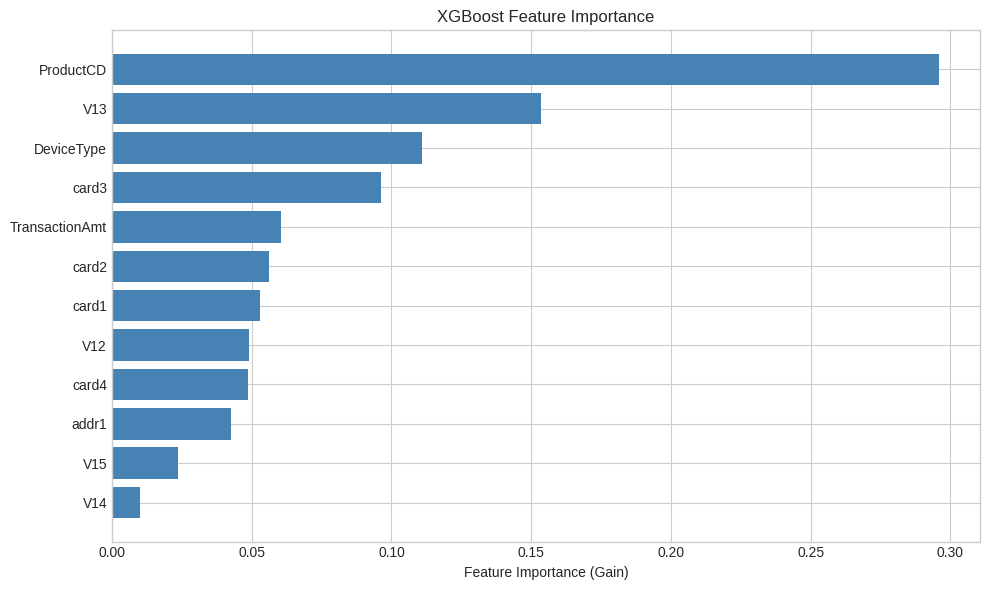

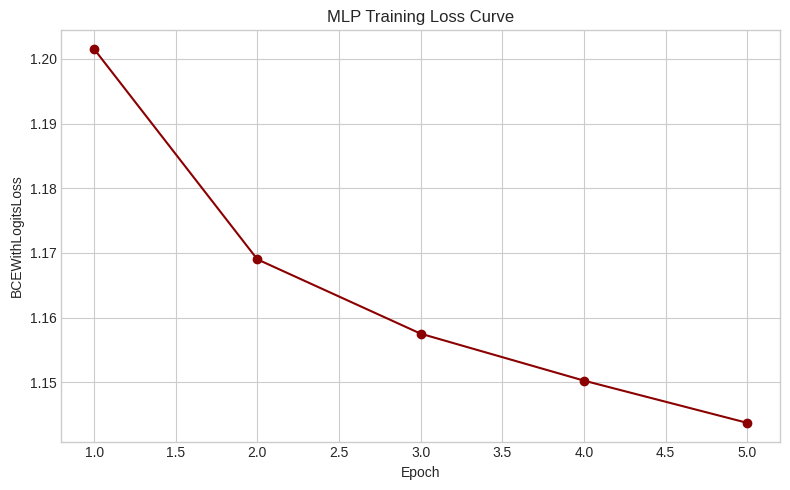


SUMMARY OF ALL MODEL METRICS
        Model ROC-AUC PR-AUC Recall@5%FPR
      XGBoost  0.7773 0.1803       0.3703
Random Forest  0.7706 0.1650       0.3451
          SVM  0.7474 0.1016       0.2052
          KNN  0.6361 0.1448       0.2531
   MLP Static  0.7544 0.1327       0.2922
 MLP Adaptive  0.7246 0.1066       0.2644


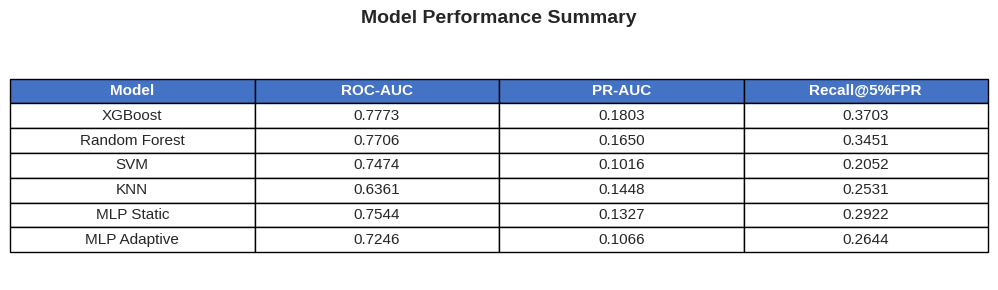

In [ ]:
# Collect all model names, predictions, and metrics
all_models = {
    'XGBoost': {'preds': y_pred_xgb, 'metrics': xgb_metrics},
    'Random Forest': {'preds': y_pred_rf, 'metrics': rf_metrics},
    'SVM': {'preds': y_pred_svm, 'metrics': svm_metrics},
    'KNN': {'preds': y_pred_knn, 'metrics': knn_metrics},
    'MLP Static': {'preds': mlp_static_probs, 'metrics': mlp_static_metrics},
    'MLP Adaptive': {'preds': None, 'metrics': mlp_adaptive_metrics},
}
model_names = list(all_models.keys())

# --- Plot 1: ROC-AUC Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
roc_aucs = [all_models[m]['metrics']['roc_auc'] for m in model_names]
colors = sns.color_palette('viridis', len(model_names))
bars = ax.bar(model_names, roc_aucs, color=colors)
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, roc_aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('roc_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 2: PR-AUC Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
pr_aucs = [all_models[m]['metrics']['pr_auc'] for m in model_names]
bars = ax.bar(model_names, pr_aucs, color=colors)
ax.set_ylabel('PR-AUC')
ax.set_title('PR-AUC Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, pr_aucs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('pr_auc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 3: Recall@5%FPR Comparison Bar Chart ---
fig, ax = plt.subplots(figsize=(10, 5))
recalls = [all_models[m]['metrics']['recall_at_5fpr'] for m in model_names]
bars = ax.bar(model_names, recalls, color=colors)
ax.set_ylabel('Recall @ 5% FPR')
ax.set_title('Recall@5%FPR Comparison Across Models')
ax.set_ylim(0, 1.05)
for bar, val in zip(bars, recalls):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.4f}', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=15)
plt.tight_layout()
plt.savefig('recall_at_5fpr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 4: Overlaid ROC Curves ---
fig, ax = plt.subplots(figsize=(8, 7))
for name in ['XGBoost', 'Random Forest', 'SVM', 'KNN', 'MLP Static']:
    preds = all_models[name]['preds']
    fpr, tpr, _ = roc_curve(y_true_stream, preds)
    roc_val = all_models[name]['metrics']['roc_auc']
    ax.plot(fpr, tpr, label=f"{name} (AUC={roc_val:.4f})")
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curves — All Static Baselines')
ax.legend(loc='lower right')
ax.grid(True)
plt.tight_layout()
plt.savefig('roc_curves_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 5: Overlaid Precision-Recall Curves ---
fig, ax = plt.subplots(figsize=(8, 7))
for name in ['XGBoost', 'Random Forest', 'SVM', 'KNN', 'MLP Static']:
    preds = all_models[name]['preds']
    prec, rec, _ = precision_recall_curve(y_true_stream, preds)
    pr_val = all_models[name]['metrics']['pr_auc']
    ax.plot(rec, prec, label=f"{name} (AUC={pr_val:.4f})")
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision-Recall Curves — All Static Baselines')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
plt.savefig('pr_curves_overlay.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 6: Class Distribution Pie Chart ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, df_plot, title in [(axes[0], hist_df, 'Training Set'), (axes[1], stream_df, 'Stream/Test Set')]:
    counts = df_plot[target_col].value_counts()
    labels = ['Non-Fraud', 'Fraud']
    ax.pie(counts, labels=labels, autopct='%1.2f%%', startangle=90,
           colors=['#2ecc71', '#e74c3c'], explode=(0, 0.1))
    ax.set_title(f'Class Distribution — {title}')
plt.tight_layout()
plt.savefig('class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 7: Confusion Matrix Heatmaps ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
threshold = 0.5
for ax, name, preds in [(axes[0], 'XGBoost', y_pred_xgb),
                         (axes[1], 'Random Forest', y_pred_rf),
                         (axes[2], 'MLP Static', mlp_static_probs)]:
    y_bin = (preds >= threshold).astype(int)
    cm = confusion_matrix(y_true_stream, y_bin)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    ax.set_title(f'Confusion Matrix — {name}')
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 8: XGBoost Feature Importance ---
fig, ax = plt.subplots(figsize=(10, 6))
importances = xgb_clf.feature_importances_
sorted_idx = np.argsort(importances)
ax.barh(np.array(feature_input_cols)[sorted_idx], importances[sorted_idx], color='steelblue')
ax.set_xlabel('Feature Importance (Gain)')
ax.set_title('XGBoost Feature Importance')
plt.tight_layout()
plt.savefig('xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 10: Training Loss Curve ---
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(1, len(training_losses) + 1), training_losses, marker='o', color='darkred')
ax.set_xlabel('Epoch')
ax.set_ylabel('BCEWithLogitsLoss')
ax.set_title('MLP Training Loss Curve')
ax.grid(True)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Plot 11: Summary Metrics Table ---
print("\n" + "="*70)
print("SUMMARY OF ALL MODEL METRICS")
print("="*70)
summary_data = []
for name in model_names:
    m = all_models[name]['metrics']
    summary_data.append([name, f"{m['roc_auc']:.4f}", f"{m['pr_auc']:.4f}", f"{m['recall_at_5fpr']:.4f}"])

summary_df = pd.DataFrame(summary_data, columns=['Model', 'ROC-AUC', 'PR-AUC', 'Recall@5%FPR'])
print(summary_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')
table = ax.table(
    cellText=summary_df.values,
    colLabels=summary_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1.2, 1.5)
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor('#4472C4')
        cell.set_text_props(color='white', fontweight='bold')
plt.title('Model Performance Summary', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('summary_table.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusion & Analysis

## Key Findings

1. **XGBoost remains a strong baseline** for tabular fraud detection, often matching or exceeding deep learning models on static evaluation.
2. **The MLP with MC Dropout** provides calibrated uncertainty estimates, which are valuable for flagging ambiguous transactions for manual review.
3. **Adaptive streaming with ADWIN drift detection** allows the model to respond to distributional changes in the transaction stream, maintaining performance over time.
4. **Class imbalance** is a dominant challenge — PR-AUC is a more informative metric than ROC-AUC for this problem due to the extreme skew.

## Model Comparison

- Traditional ML baselines (Random Forest, SVM, KNN) provide useful reference points.
- The **adaptive MLP** benefits from online updates, particularly after detected drift events.
- **Recall@5%FPR** highlights each model's ability to detect fraud while maintaining a low false alarm rate — critical for real-world deployment.

## Limitations

- The streaming simulation uses a fixed delay and chunk size; real-world systems would need dynamic scheduling.
- Only a subset of available features is used; incorporating more features (V-columns, identity features) could improve performance.
- The MC Dropout uncertainty threshold (0.02) is a hyperparameter that should be tuned per deployment.

## Future Work

- Integrate **graph neural networks** to capture transaction network structure.
- Explore **ensemble methods** combining XGBoost and MLP predictions.
- Deploy as a **real-time API** with monitoring dashboards for production use.
- Investigate **federated learning** for privacy-preserving fraud detection across institutions.

# 11. DEPLOYMENT DEMO & EXPORT

In [ ]:
def predict_transaction(transaction_dict):
    """Simulates API endpoint"""
    model.eval()
    processed_values = {} # Use a dictionary to store values with their column names

    for col in feature_input_cols:
        val = transaction_dict.get(col, 0)
        # Handle categorical encoding (naive lookup)
        if col in encoders_dict:
            try:
                val = encoders_dict[col].transform([str(val)])[0]
            except ValueError:
                # If a category is not seen during training, default to 0
                val = 0
        processed_values[col] = float(val)

    # Convert the processed values to a DataFrame
    input_df = pd.DataFrame([processed_values])

    # Scale only the numerical features. Passing a DataFrame ensures feature names are used.
    input_df[num_cols] = scaler.transform(input_df[num_cols])

    # Convert the DataFrame to a tensor, ensuring column order is maintained
    x_tensor = torch.tensor(input_df[feature_input_cols].values, dtype=torch.float32).to(device)

    with torch.no_grad():
        logits = model(x_tensor)
        prob = torch.sigmoid(logits).item()

    return {"fraud_probability": prob, "alert": "HIGH RISK" if prob > 0.8 else "OK"}

# Test API
dummy_tx = stream_df.iloc[0].to_dict()
print(f"\n[API TEST] Input Amount: {dummy_tx['TransactionAmt']}")
print(f"[API TEST] Output: {predict_transaction(dummy_tx)}")

# Export artifacts
torch.save(model.state_dict(), 'fraud_mlp.pth')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(encoders_dict, 'encoders.pkl')
joblib.dump(feature_input_cols, 'feature_cols.pkl')
df_res.to_csv('final_results.csv', index=False)

print("\nAll files saved! Ready for App building.")


[API TEST] Input Amount: 0.3803810893393937
[API TEST] Output: {'fraud_probability': 0.5103116631507874, 'alert': 'OK'}

All files saved! Ready for App building.
